In [97]:
!pip install scikit-learn

In [150]:
from sklearn.datasets import fetch_kddcup99
import numpy as np
import matplotlib.pyplot as plt

# Loading the `kddcup99` dataset

In [151]:
kdd = fetch_kddcup99(return_X_y=True)

data = kdd[0]
targets = kdd[1]

In [155]:
attacks, counts = np.unique(targets, return_counts=True)
ypos = np.arange(len(attacks))

attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

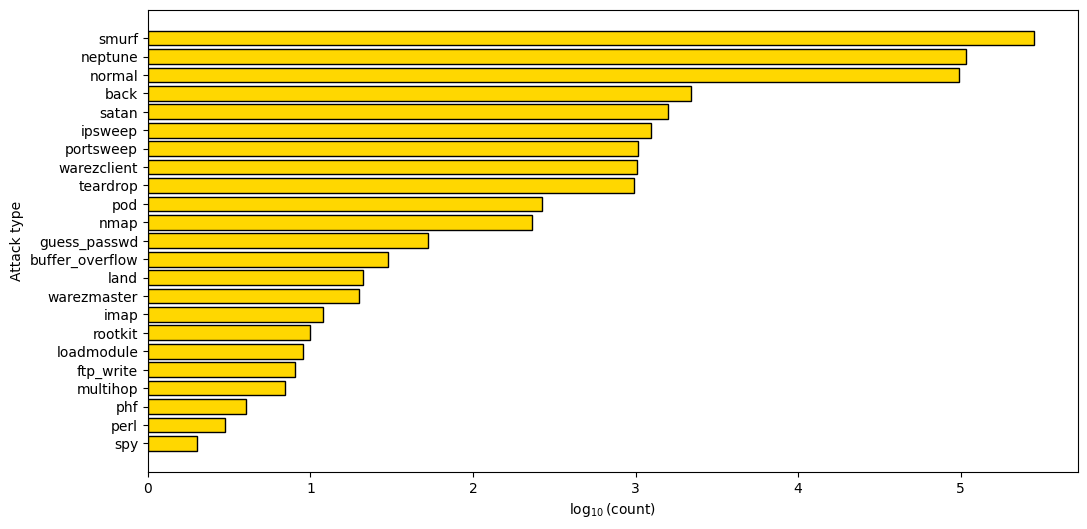

In [168]:
plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), edgecolor="k", facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

In [67]:
kdd[0][:, 6]

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [53]:
type(b"tcp")

bytes

In [54]:
bytes(b"tcp")

b'tcp'

In [55]:
str(b"tcp")

"b'tcp'"

In [59]:
a = b"tcp"
a.decode("utf-8")

'tcp'

In [61]:
import sys

bin(int.from_bytes(b'tcp', byteorder=sys.byteorder))

'0b11100000110001101110100'